# Load and Read the dataset

In [1069]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [1070]:
#read the data
df = pd.read_csv('MavenRail.csv')

# Inital Observation

In [1071]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31645 entries, 0 to 31644
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Payment.Method     31645 non-null  object
 1   Railcard           10734 non-null  object
 2   Ticket.Class       31645 non-null  object
 3   Ticket.Type        31645 non-null  object
 4   Price              31645 non-null  int64 
 5   Departure.Station  31645 non-null  object
 6   Arrival.Station    31645 non-null  object
 7   Departure          31642 non-null  object
 8   Scheduled.Arrival  31641 non-null  object
 9   Actual.Arrival     29765 non-null  object
 10  Journey.Status     31645 non-null  object
 11  Reason.for.Delay   4166 non-null   object
 12  Refund.Request     31645 non-null  object
dtypes: int64(1), object(12)
memory usage: 3.1+ MB


In [1072]:
#Create table to shows typical records in the dataset
typical_records = df.head(4)
transposed_df = typical_records.transpose()
transposed_df.columns = [f'Row {i+1}' for i in range(transposed_df.shape[1])]
transposed_df.fillna('None',inplace=True)

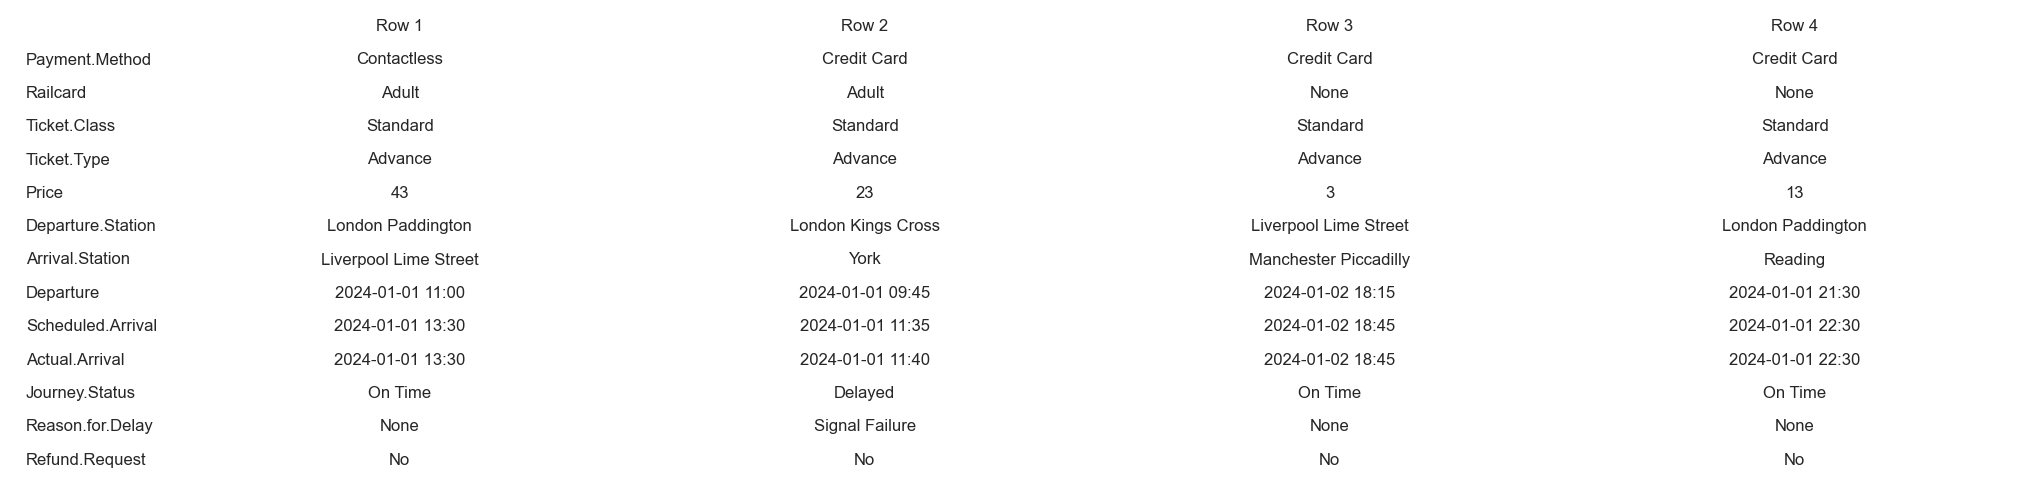

In [1073]:
#Plot the table using Matplotlib
fig, ax = plt.subplots(figsize=(12,6))

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

table = ax.table(cellText = transposed_df.values,
                 rowLabels = transposed_df.index,
                 colLabels = transposed_df.columns,
                 cellLoc = 'center',
                 loc = 'center',
                 edges = '',)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(2,2)

plt.show()

In [1074]:
#Initial Observations
#Finding the duplicated records in the dataset
duplicated_records = df.duplicated().sum()
print(f'There are {duplicated_records} duplicated records. Which is equivalent to {round((duplicated_records/31645)*100,2)}% of the total records')

There are 5631 duplicated records. Which is equivalent to 17.79% of the total records


## Data Preparation

In this part, I will:
- Drop records having missing values in Departure and Scheduled.Arrival
- Update the missing values in Railcard and Reason.for.Delay to 'None'
- Transform the columns into the appropriate forms of data types of analytical purposes

In [1075]:
#Remove records having missing values in Departure and Scheduled.Arrival
df.dropna(subset=['Departure', 'Scheduled.Arrival'],inplace=True)

#Update the missing values in Railcard and Reason.for.Delay to 'None'
df['Railcard'].fillna('None',inplace=True)
df['Reason.for.Delay'].fillna('None',inplace=True)

#Transform the data types of Departure, Scheduled.Arrival and Actual.Arrival from object to datetime
df["Departure"] = pd.to_datetime(df["Departure"], format="%Y-%m-%d %H:%M")
df["Scheduled.Arrival"] = pd.to_datetime(df["Scheduled.Arrival"], format="%Y-%m-%d %H:%M")
df["Actual.Arrival"] = pd.to_datetime(df["Actual.Arrival"], format="%Y-%m-%d %H:%M")

/var/folders/02/r4n5pmm16xzc0p1m4wrn_70r0000gn/T/ipykernel_6421/2558074657.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Railcard'].fillna('None',inplace=True)
/var/folders/02/r4n5pmm16xzc0p1m4wrn_70r0000gn/T/ipykernel_6421/2558074657.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

In [1076]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31639 entries, 0 to 31644
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Payment.Method     31639 non-null  object        
 1   Railcard           31639 non-null  object        
 2   Ticket.Class       31639 non-null  object        
 3   Ticket.Type        31639 non-null  object        
 4   Price              31639 non-null  int64         
 5   Departure.Station  31639 non-null  object        
 6   Arrival.Station    31639 non-null  object        
 7   Departure          31639 non-null  datetime64[ns]
 8   Scheduled.Arrival  31639 non-null  datetime64[ns]
 9   Actual.Arrival     29762 non-null  datetime64[ns]
 10  Journey.Status     31639 non-null  object        
 11  Reason.for.Delay   31639 non-null  object        
 12  Refund.Request     31639 non-null  object        
dtypes: datetime64[ns](3), int64(1), object(9)
memory usage: 3.4+ MB


In [1077]:
#Check for invalid records where Departure time is later than either Scheduled.Arrival or Actual.Arrival

invalid_records = df[
    (df['Departure'] > df['Scheduled.Arrival']) |
    (df['Departure'] > df['Actual.Arrival'])
]

invalid_records.shape

(959, 13)

In [1078]:
df.drop(invalid_records.index, inplace=True)
df.shape

(30680, 13)

# Task 2: Exploratory Data Analysis on the Dataset

### Univariate Analysis

### Analyse Categorical Features

In [1079]:
df['Payment.Method'].value_counts()

Payment.Method
Credit Card    18580
Contactless    10420
Debit Card      1680
Name: count, dtype: int64

In [1080]:
df['Ticket.Type'].value_counts()

Ticket.Type
Advance     17037
Off-Peak     8303
Anytime      5340
Name: count, dtype: int64

In [1081]:
df['Ticket.Class'].value_counts()

Ticket.Class
Standard       27719
First Class     2961
Name: count, dtype: int64

In [1082]:
df['Railcard'].value_counts()

Railcard
None        20323
Adult        4652
Disabled     2922
Senior       2783
Name: count, dtype: int64

In [1083]:
df['Departure.Station'].value_counts()

Departure.Station
Manchester Piccadilly    5599
London Euston            4739
Liverpool Lime Street    4441
London Paddington        4355
London Kings Cross       4038
London St Pancras        3856
Birmingham New Street    2102
York                      761
Reading                   578
Oxford                    144
Edinburgh Waverley         51
Bristol Temple Meads       16
Name: count, dtype: int64

In [1084]:
df['Arrival.Station'].value_counts()

Arrival.Station
Birmingham New Street    7607
Liverpool Lime Street    5020
York                     3827
Reading                  3775
Manchester Piccadilly    3768
London Euston            1500
London St Pancras         748
Oxford                    623
Leicester                 337
London Paddington         318
Sheffield                 272
Peterborough              242
Leeds                     239
Swindon                   228
Tamworth                  227
Nuneaton                  219
Doncaster                 211
Crewe                     193
Stafford                  190
Edinburgh Waverley        178
Nottingham                158
Bristol Temple Meads      144
Edinburgh                 122
Wolverhampton             115
Durham                    108
London Kings Cross         84
London Waterloo            68
Coventry                   65
Didcot                     48
Cardiff Central            16
Wakefield                  15
Warrington                 15
Name: count, dtype: int6

In [1085]:
df['Journey.Status'].value_counts()

Journey.Status
On Time      26560
Delayed       2288
Cancelled     1832
Name: count, dtype: int64

In [1086]:
df['Reason.for.Delay'].value_counts()

Reason.for.Delay
None               26560
Weather             1359
Signal Failure       952
Technical Issue      702
Staffing             401
Staff                399
Traffic              307
Name: count, dtype: int64

In [1087]:
df['Refund.Request'].value_counts()

Refund.Request
No     29585
Yes     1095
Name: count, dtype: int64

### What is the peak of the departure time throughout the day?

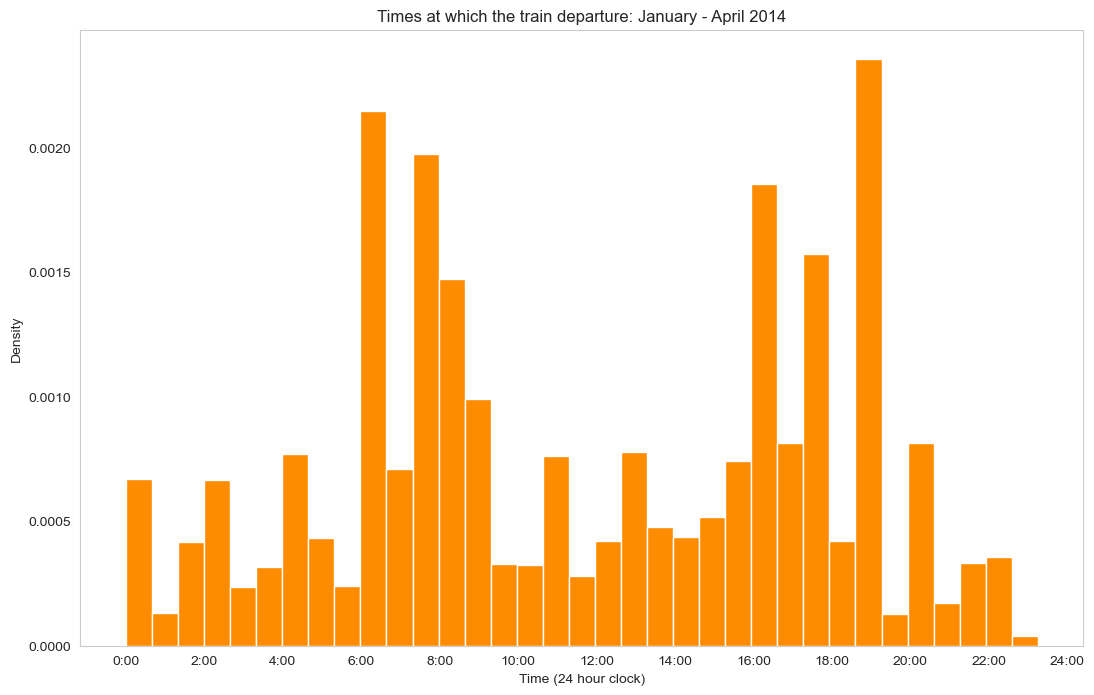

In [1088]:
#Get time-since-midnight for departure time to represent departure time as a continuous numerical variable
#TSM stands for time since midnight

#Add this column to the dataframe
df["Departure.TSM"] = df["Departure"].apply(lambda x: x.hour * 60 + x.minute)

#Plot the Figure for the question
height = 8
goldenMean = (1 + math.sqrt(5.0))/ 2.0

fig, ax = plt.subplots(1, 1, figsize=(goldenMean*height, height))
plt.hist(df["Departure.TSM"],bins='fd',density = True, color='#FF8C00')
plt.xlabel("Time (24 hour clock)")
plt.ylabel("Density")

#Label the x-axis with time
hours = np.arange(0, 1441, 120)
labels = [f'{int(h // 60)}:00' for h in hours]
ax.set_xticks(hours)
ax.set_xticklabels(labels)
ax.grid(False)

plt.title("Times at which the train departure: January - April 2014")
#plt.savefig('Figures/DepartureTime_Distribution.svg')
plt.show()

### What is the distribution of ticket price?

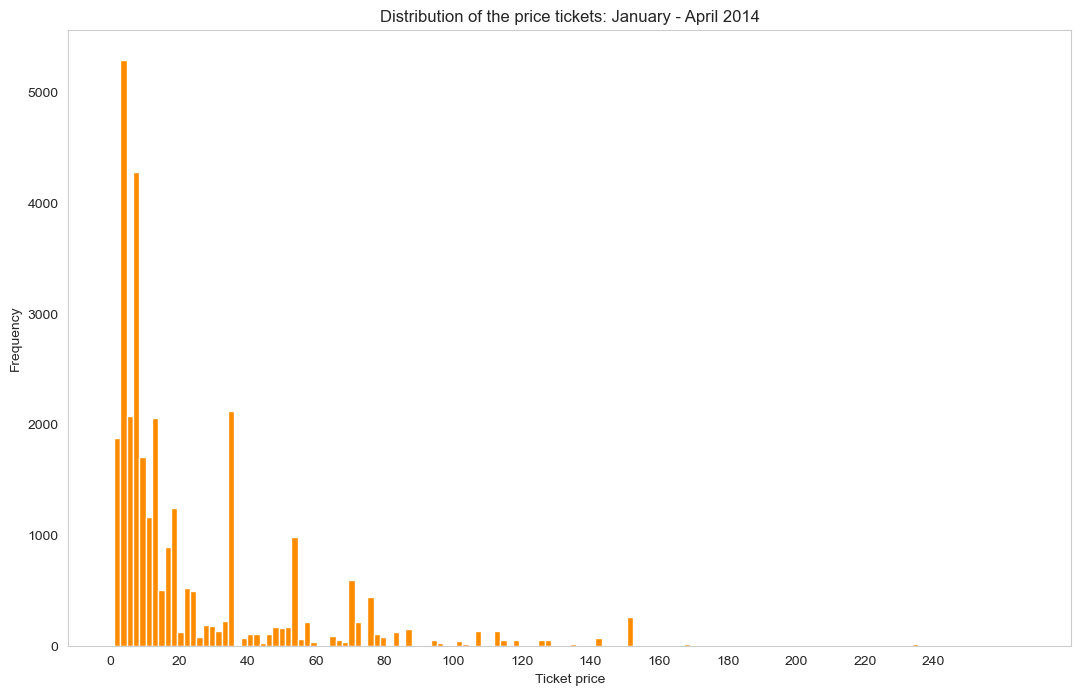

In [1089]:
#Plot a histogram to show the distribution of Price

fig, ax = plt.subplots(1, 1, figsize=(goldenMean*height, height))
plt.hist(df["Price"],bins='fd', color='#FF8C00')
plt.xlabel("Ticket price")
plt.ylabel("Frequency")
plt.xticks(range(0,250,20))
ax.grid(False)

plt.title("Distribution of the price tickets: January - April 2014")
#plt.savefig('Figures/Price_Distribution.svg')
plt.show()

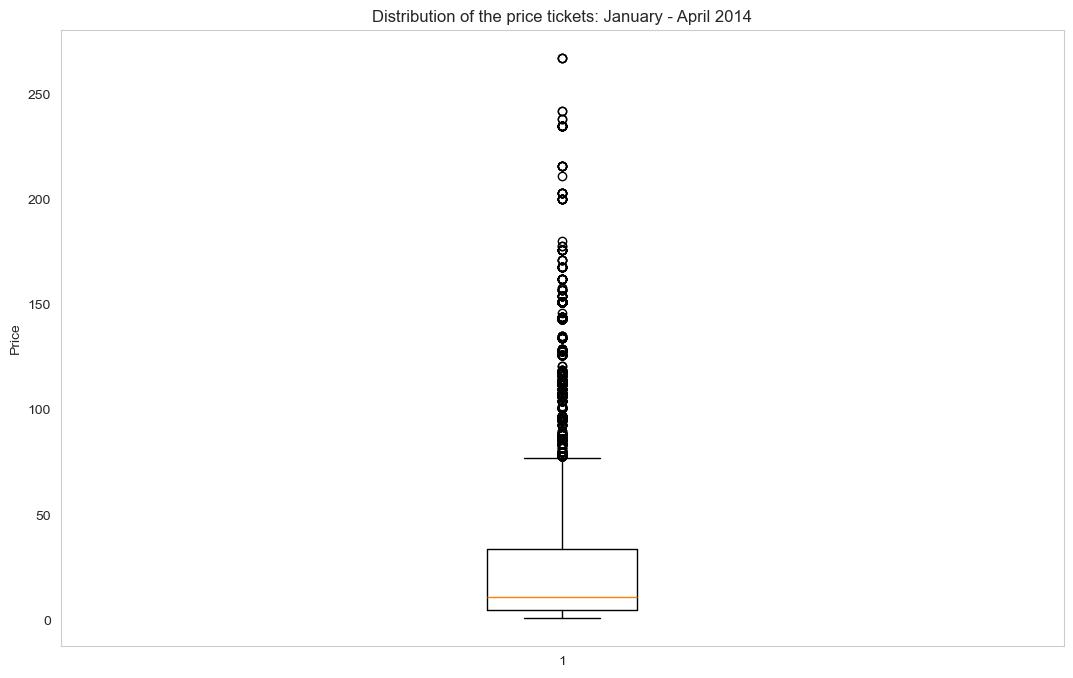

In [1090]:
#Plot the boxplot to observe the distribution of Price

fig, ax = plt.subplots(1, 1, figsize=(goldenMean*height, height))
plt.boxplot(df["Price"])
plt.ylabel("Price")
ax.grid(False)

plt.title("Distribution of the price tickets: January - April 2014")
#plt.savefig('Figures/Price_Distribution_Boxplot.svg')
plt.show()

In [1091]:
#Create a dataframe to show which National Rail stations are busiest
#The index of Departure and Arrival column will be re-indexed based the union between departure and arrival value_counts()
departure_count = df['Departure.Station'].value_counts()
arrival_count = df['Arrival.Station'].value_counts()

station_visits = pd.DataFrame({
    'National Rail Station': departure_count.index.union(arrival_count.index),
    'Departure': departure_count.reindex(departure_count.index.union(arrival_count.index)).fillna(0).astype(int),
    'Arrival': arrival_count.reindex(departure_count.index.union(arrival_count.index)).fillna(0).astype(int)
}).reset_index(drop=True)

#sorting the dataframe by total visits:
station_visits["Total visits"] = station_visits['Arrival'] + station_visits['Departure']
station_visits.sort_values(by='Total visits', ascending=False, inplace=True)

station_visits

,National Rail Station,Departure,Arrival,Total visits
0,Birmingham New Street,2102,7607,9709
12,Liverpool Lime Street,4441,5020,9461
18,Manchester Piccadilly,5599,3768,9367
13,London Euston,4739,1500,6239
15,London Paddington,4355,318,4673
16,London St Pancras,3856,748,4604
31,York,761,3827,4588
23,Reading,578,3775,4353
14,London Kings Cross,4038,84,4122
21,Oxford,144,623,767


### Which stations are the busiest?

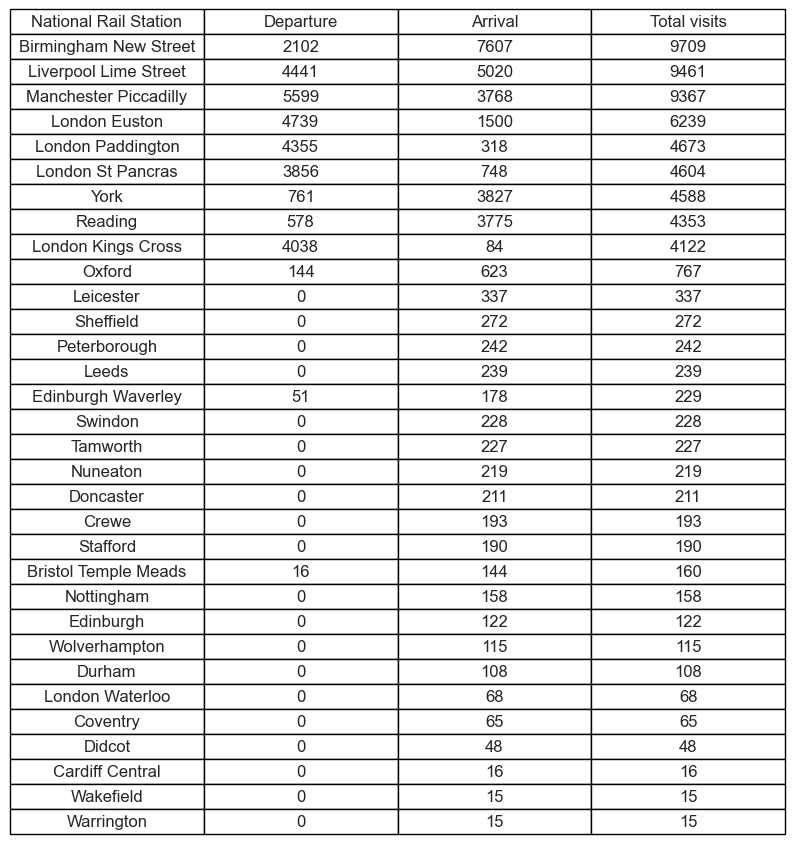

In [1092]:
#Plot the table

fig, ax = plt.subplots(1, 1, figsize=(10,2))
ax.axis('off')
table = plt.table(cellText = station_visits.values,
                  colLabels = station_visits.columns,
                  cellLoc = 'center',
                  loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1,1.5)

table

### How does the departure vary from station to station?

#### Departure Station

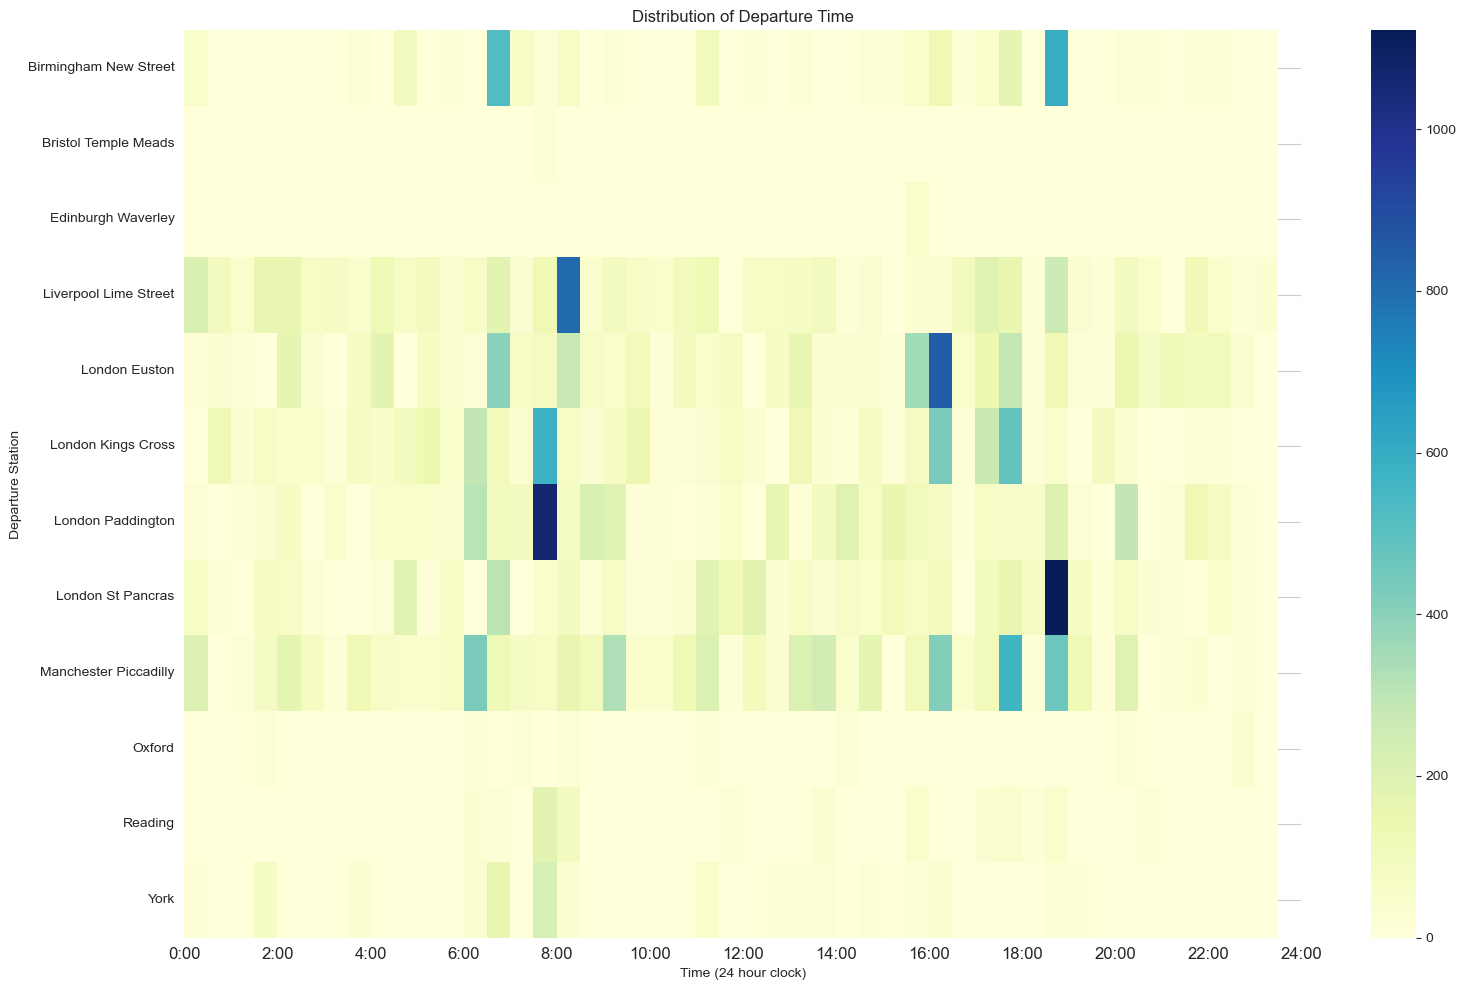

In [1093]:
#Create a heatmap strip to show how the departure vary from station to station

#Make a pivot table for station and 30-minute intervals
station_departure_pivot = df.pivot_table(
    index = 'Departure.Station',
    columns = df['Departure.TSM']//30,
    aggfunc = 'size',
    fill_value = 0
)

fig, ax = plt.subplots(figsize=(16,10))
sns.heatmap(station_departure_pivot, cmap = 'YlGnBu', cbar = True)

#Setting xticks to represent hour in a day
hours = np.arange(0, 25, 2)
position = (hours/24) * (24*2)
label = [f'{h}:00' for h in hours]
plt.xticks(position, label, fontsize=12)

plt.title('Distribution of Departure Time')
plt.xlabel('Time (24 hour clock)')
plt.ylabel('Departure Station')
plt.tight_layout()
plt.show()

#### Arrival Station

In [1094]:
#Get time-since-midnight for arrival time to represent arrival time as a continuous numerical variable
#TSM stands for time since midnight

#Add this column to the dataframe
df["Arrival.TSM"] = df["Scheduled.Arrival"].apply(lambda x: x.hour * 60 + x.minute)

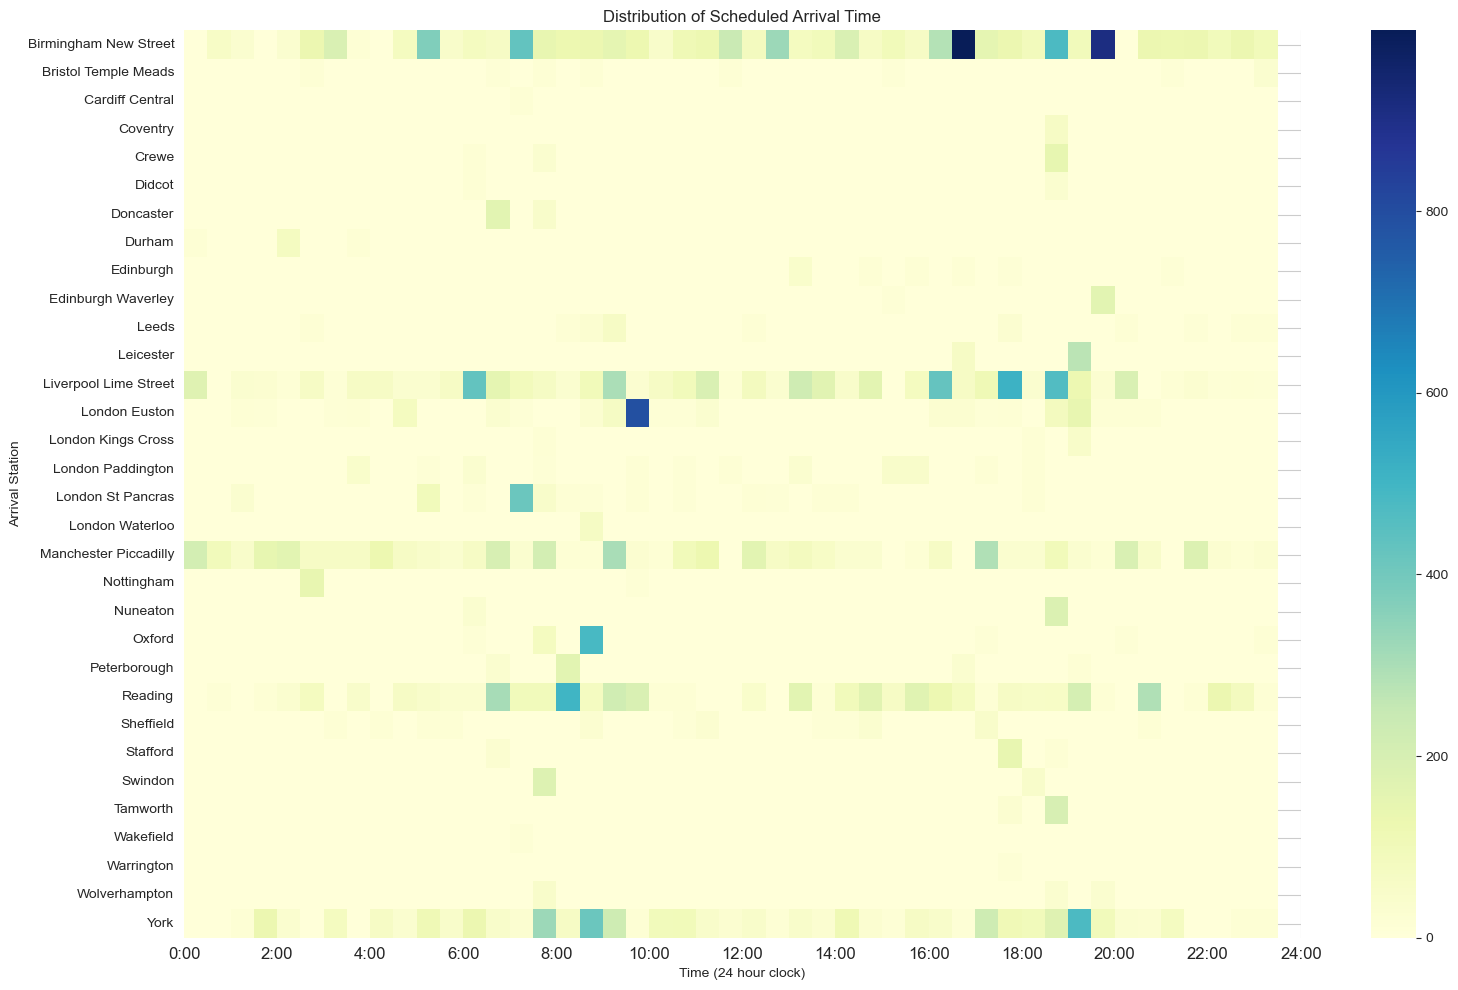

In [1095]:
#Create a heatmap strip to show how the scheduled.arrival vary from station to station

#Make a pivot table for station and 30-minute intervals
station_arrival_pivot = df.pivot_table(
    index = 'Arrival.Station',
    columns = df['Arrival.TSM']//30,
    aggfunc = 'size',
    fill_value = 0
)

fig, ax = plt.subplots(figsize=(16,10))
sns.heatmap(station_arrival_pivot, cmap = 'YlGnBu', cbar = True)

#Setting xticks to represent hour in a day
hours = np.arange(0, 25, 2)
position = (hours/24) * (24*2)
label = [f'{h}:00' for h in hours]
plt.xticks(position, label, fontsize=12)

plt.title('Distribution of Scheduled Arrival Time')
plt.xlabel('Time (24 hour clock)')
plt.ylabel('Arrival Station')
plt.tight_layout()
plt.show()

### How the distribution of ticket price differ between Refund Requests

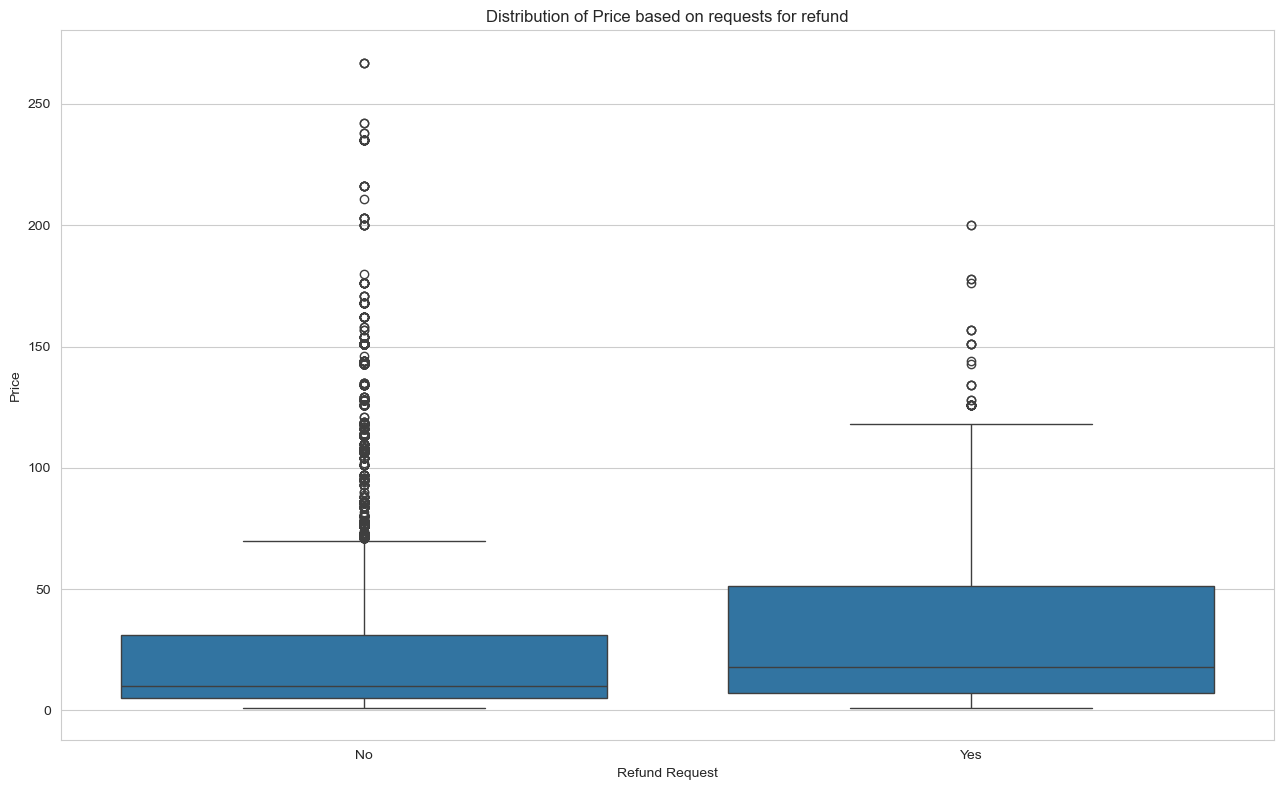

In [1096]:
fig, ax = plt.subplots(1, 1, figsize=(goldenMean*height, height))
sns.boxplot(df, x = 'Refund.Request', y = 'Price')

plt.title("Distribution of Price based on requests for refund")
plt.xlabel("Refund Request")
plt.ylabel("Price")
plt.xticks(['No','Yes'])
plt.tight_layout()
plt.show()

# Task 3

Add a column, DelayInMinutes,to the dataset that gives the duration of the delay in minutes, if the journey was delayed. If the train arrived on time, set DelayInMinutes to NA.

In [1097]:
df['DelayInMinutes'] = (df['Actual.Arrival'] - df['Scheduled.Arrival']).dt.total_seconds()/60
df['DelayInMinutes'] = df.apply(
     lambda x: x['DelayInMinutes'] if x['Journey.Status'] == 'Delayed' else pd.NA, axis = 1
)

# Task 4

Restrict attention to those journeys where Journey.Status is not On Time and add a column, MediumPrice, to the resulting dataset that answers the question: Does the ticket price lie in the range: £10 < Price ≤ £30?

Fit an appropriate regression model that predicts whether a passenger will request a refund using MediumPrice as a single predictor. With the help of the fitted model, answer the following questions (show your calculations, either by hand or with help of R or Python):
- What is the probability that a passenger will request a refund, given that they paid £5 for their ticket?
- What is the probability that a passenger will request a refund, given that their ticket cost £25?

In [1098]:
#Restricting to journeys where Journey.Status is not 'On Time'
df_4 = df[df['Journey.Status'] != 'On Time']

#Add a column MediumPrice
df_4['MediumPrice'] = df_4['Price'].apply(lambda x: 1 if 10 < x <= 30 else 0) 

/var/folders/02/r4n5pmm16xzc0p1m4wrn_70r0000gn/T/ipykernel_6421/2997109689.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4['MediumPrice'] = df_4['Price'].apply(lambda x: 1 if 10 < x <= 30 else 0)


In [1099]:
y = (df_4['Refund.Request'] == 'No').astype(int)

print(y)

1        1
8        1
20       0
26       0
39       1
        ..
31631    1
31633    0
31634    1
31636    1
31637    1
Name: Refund.Request, Length: 4120, dtype: int64


In [1100]:
X = df_4['MediumPrice']
y = (df_4['Refund.Request'] == 'Yes').astype(int)

#Transform X_train into a Dataframe
X = pd.DataFrame(X)

#Fit the train data into Logistic Regression model
model = LogisticRegression()
model.fit(X, y)

accuracy = model.score(X, y)
print(accuracy)

0.7342233009708737


In [1101]:
print(model.intercept_)
print(model.coef_)

[-1.0829441]
[[0.3506518]]


In [1102]:
#Calculate the probability prediction for a passenger will request a refund, given that they paid £5 for their ticket
prob_5 = model.predict_proba([[0]])
prob_5

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([[0.74705072, 0.25294928]])

In [1103]:
#Calculate the probability prediction for a passenger will request a refund, given that they paid £25 for their ticket
prob_25 = model.predict_proba([[1]])
prob_25

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([[0.6753081, 0.3246919]])

# Task 5

In [1104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30680 entries, 0 to 31644
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Payment.Method     30680 non-null  object        
 1   Railcard           30680 non-null  object        
 2   Ticket.Class       30680 non-null  object        
 3   Ticket.Type        30680 non-null  object        
 4   Price              30680 non-null  int64         
 5   Departure.Station  30680 non-null  object        
 6   Arrival.Station    30680 non-null  object        
 7   Departure          30680 non-null  datetime64[ns]
 8   Scheduled.Arrival  30680 non-null  datetime64[ns]
 9   Actual.Arrival     28848 non-null  datetime64[ns]
 10  Journey.Status     30680 non-null  object        
 11  Reason.for.Delay   30680 non-null  object        
 12  Refund.Request     30680 non-null  object        
 13  Departure.TSM      30680 non-null  int64         
 14  Arrival.TSM

In [1105]:
#Split the data into train and test set
x = df.drop(['Refund.Request', 'Departure', 'Scheduled.Arrival', 'Actual.Arrival', 'DelayInMinutes', 'Departure.TSM', 'Arrival.TSM','Arrival.Station','Departure.Station'], axis = 1, inplace = False)
y = df['Refund.Request']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#Transform the target into numerical values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

#Transform Ordinal Features
ticket_class_order = [['Standard', 'First Class']]
ord_transformer = Pipeline(steps=[(
    'encoder', OrdinalEncoder(categories=ticket_class_order)
)])

#Using One-hot to transform Nominal features
nom_transformer = Pipeline(steps=[(
    'encoder', OneHotEncoder(sparse_output=False)
)])

preprocessor = ColumnTransformer(transformers=[
    ('nom_feature', nom_transformer, ['Payment.Method', 'Railcard', 'Ticket.Type',
                                      'Journey.Status', 'Reason.for.Delay']),
    ('ordinal_feature', ord_transformer, ['Ticket.Class'])
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('scaler', StandardScaler())
])

pipeline.fit(x_train)
x_train = pipeline.transform(x_train)

In [1106]:
#Fit the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

In [1107]:
#Transform the test set to evaluate the accuracy score
y_test = label_encoder.transform(y_test)
x_test = preprocessor.transform(x_test)

y_pred = model.predict(x_test)

acc = accuracy_score(y_test,y_pred)

In [1108]:
print(acc)

0.9364406779661016


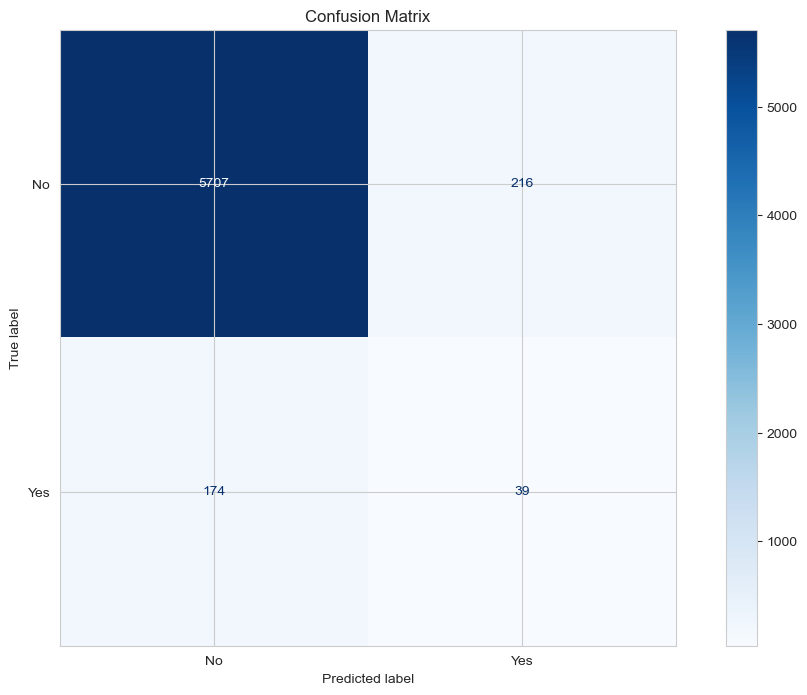

In [1109]:
#Plot the confusion matrix

cm = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(goldenMean*height, height))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format = 'd', ax=plt.gca())

plt.title("Confusion Matrix")
plt.show()

In [1110]:
#Load and Transform the data of Test.csv to fit into the model
test_df = pd.read_csv('ToPredict.csv')

test_df['Railcard'].fillna('None',inplace=True)
test_df['Reason.for.Delay'].fillna('None',inplace=True)

x_topredict = test_df.drop(['Departure', 'Scheduled.Arrival', 'Actual.Arrival'], axis = 1, inplace = False)
x_topredict = preprocessor.transform(x_topredict)

/var/folders/02/r4n5pmm16xzc0p1m4wrn_70r0000gn/T/ipykernel_6421/1773323827.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['Railcard'].fillna('None',inplace=True)
/var/folders/02/r4n5pmm16xzc0p1m4wrn_70r0000gn/T/ipykernel_6421/1773323827.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always 

In [1111]:
#Predict the probability of having refund request in each observation in ToPredict.csv
prob = model.predict_proba(x_topredict)

probabilities = [
    f"Row {i+1}: {prob[0] * 100:.2f}% No Refund, {prob[1] * 100:.2f}% Refund"
    for i, prob in enumerate(prob)
]

probabilities

['Row 1: 99.19% No Refund, 0.81% Refund',
 'Row 2: 100.00% No Refund, 0.00% Refund',
 'Row 3: 0.80% No Refund, 99.20% Refund',
 'Row 4: 99.98% No Refund, 0.02% Refund',
 'Row 5: 99.98% No Refund, 0.02% Refund',
 'Row 6: 99.99% No Refund, 0.01% Refund',
 'Row 7: 0.17% No Refund, 99.83% Refund',
 'Row 8: 99.85% No Refund, 0.15% Refund']